## TFIM (EE, 分割時間, 横磁場, 周期境界条件なし)

\[
H = - J \sum_i S_i^z S_{i+1}^z \;-\; h_x \sum_i S_i^x
\]

In [3]:
import qutip as qt
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec

In [28]:
# =========
T_total, nt = 20.0, 200
tlist = np.linspace(0.0, T_total, nt)
# =========

def simulate(N, J, hx, T_cut):
    cut_pos = N // 2 - 1
    sx, sy, sz = [0.5*M for M in (qt.sigmax(), qt.sigmay(), qt.sigmaz())]
    I2 = qt.qeye(2)

    def op_at(i, op):
        return qt.tensor([op if k == i else I2 for k in range(N)])

    Sx = [op_at(i, sx) for i in range(N)]
    Sy = [op_at(i, sy) for i in range(N)]
    Sz = [op_at(i, sz) for i in range(N)]

    def H_exchange(i):
        return (Sz[i] * Sz[i+1])

    def H_trans(i):
        return Sx[i]

    H_cut_unit = H_exchange(cut_pos)
    H_exchange_unit = sum(H_exchange(i) for i in range(N-1) if i != cut_pos)
    H_trans_unit = sum(H_trans(i) for i in range(N))
    H_full = -J * (H_exchange_unit + H_cut_unit) - hx * H_trans_unit

    H_static = -J * (H_exchange_unit) - hx * H_trans_unit
    left_sides = list(range(N//2))
    solver_opts = dict(store_states=False, progress_bar =None, rtol = 1e-6, atol=1e-8, nsteps=20000)


    def ramp(t, T_cut):
        if T_cut <= 0.0:
            return 1.0 if t <= 0.0 else 0.0
        if t <= 0.0:
            return 1.0
        if t >= T_cut:
            return 0.0
        return 1.0 - t / T_cut

    def coeff(t, T_cut, J, args=None):
        return - J * ramp(t, T_cut)

    def make_H_time(T_cut: float, J: float):
        return [H_static, [ - J * H_cut_unit, lambda t, args: ramp(t, T_cut)]]

    def EE_op(t, state, args=None):
        rhoL = qt.ptrace(state, left_sides)
        return float(qt.entropy_vn(rhoL, base=2))

    def run_EE_curve(T_cut: float, J: float, psi0):
        H_time = make_H_time(T_cut, J)
        sol = qt.sesolve(H_time, psi0, tlist, e_ops=[EE_op], options=solver_opts)
        return np.array(sol.expect[0])


    _, psi_ground = H_full.groundstate(sparse=True)
    return run_EE_curve(T_cut, J, psi_ground)

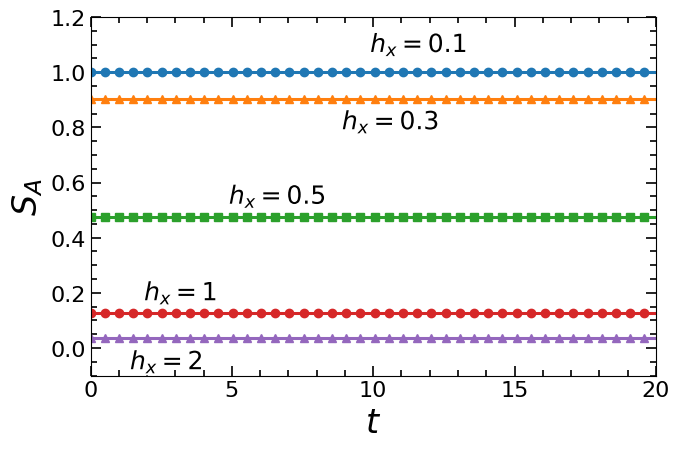

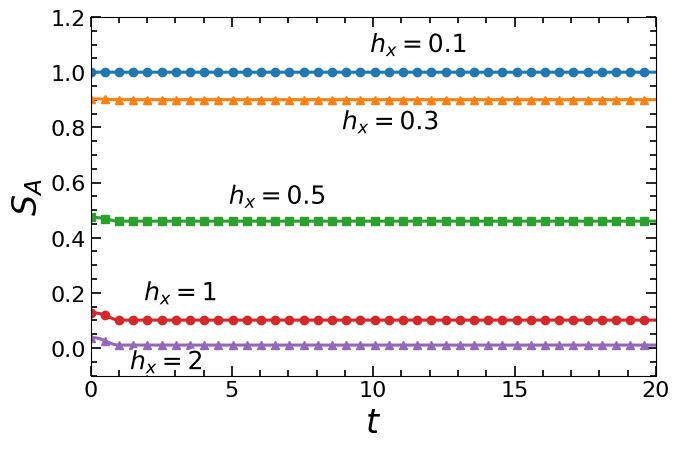

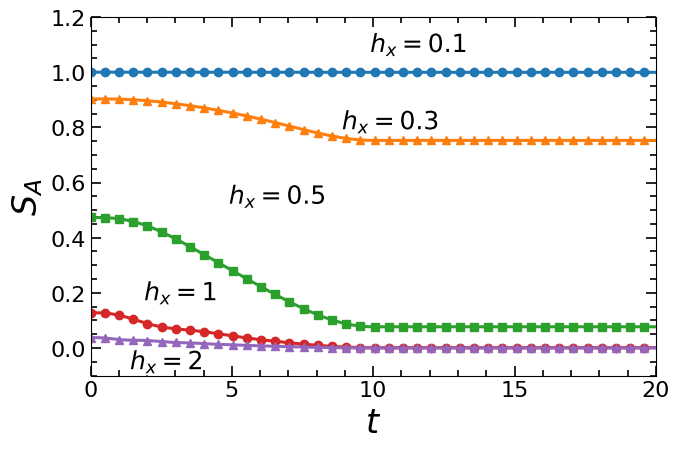

In [47]:
def label_at(ax, x, y, text, *, coord='data', dx_pt = 8, fontsize=14, color=None):
    kw = dict(ha='left', va='center', fontsize=fontsize, xytext=(dx_pt, 0), textcoords='offset points', path_effects=[pe.withStroke(linewidth = 3, foreground='white')], clip_on=False, zorder=6)
    if color is not None:
        kw['color'] = color
    if coord == 'axes':
        ax.annotate(text, xy = (x, y), xycoords = ax.transAxes, **kw)
    else:
        ax.annotate(text, xy = (x, y), xycoords = 'data', **kw)

def inward_ticks(ax, major_len=7, minor_len=4, width=1.2):
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True, length=major_len, width=width)
    ax.tick_params(which='minor', length=minor_len, width=width)

def relax(ax, y):
    ax.axhline(y=y[0]/np.e, color=ax.lines[-1].get_color(), ls=':', lw=ax.lines[-1].get_linewidth())


markers = ['o', '^', 's']
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
mpl.rcParams.update({
    "axes.labelsize": 18,   # 軸ラベル
    "xtick.labelsize": 16,  # 目盛り数字
    "ytick.labelsize": 16,
    "lines.linewidth": 2.2, # 線の太さ
    "axes.titlesize": 16,
})

pos1 = { 
    # 0.0: (6.5, 1.1),
    0.1: (9.5, 1.1),
    0.3: (8.5, 0.82),
    0.5: (4.5, 0.55),
    1.0: (1.5, 0.20),
    2.0: (1.0, -0.05)}

hx_list = [0.1, 0.3, 0.5, 1.0, 2.0]
T_cut_list  = [0.0, 1.0, 10.0]

for T_cut in T_cut_list:
    fig, ax = plt.subplots(figsize=(6.9, 4.6))
    inward_ticks(ax)
    ax.set_xlim(0.0, 20.0)
    ax.set_xlabel(r"$t$", fontsize=24)
    ax.set_ylim(-0.1, 1.2)
    ax.set_ylabel(r"$S_A$", fontsize=24)
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    fig.tight_layout()
    OUTDIR = Path("charts/TFIM")
    
    for i, hx in enumerate(hx_list):
        x = tlist
        y = simulate(N = 6, hx = hx, J = 1.0, T_cut = T_cut)
        step = 5
        mk = markers[i % len(markers)]
        ln, = ax.plot(x, y, markevery=step, marker=mk, markersize=6.0)
        label_at(ax, *pos1[hx], fr"$h_x={hx:g}$", coord='data', fontsize=18)
        # relax(ax, y)

    fig.savefig(OUTDIR/f"SA_cut_T_cut_{T_cut}.pdf", bbox_inches="tight", dpi=300)
        
    plt.show()
    
        
        